# Combine results from multiple ERDDAPs

In this notebook we use data from one ERDDAP (OSMC animal-borne sensors) to make subsequent queries to other ERDDAPs supplying Argo and satellite data

In [1]:
import datetime
import pandas as pd
from erddapy import ERDDAP
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


def cartopy_map(lon, lat):
    central_lon = (lon.min() + lon.max())/2
    central_lat = (lat.min() + lat.max())/2
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(projection=ccrs.AzimuthalEquidistant(central_latitude=central_lat, central_longitude=central_lon))
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.gridlines(color='k', alpha=0.2)
    #ax.set_extent([lon.min()-0.5, lon.max()+0.5, lat.min()-0.5, lat.max()+1.5], crs=ccrs.PlateCarree())
    return ax

### 1. MEOPS animals

We can use ERDDAP's built in search function to find datasets that match a keyword. Let's find some animal borne sensor data

In [2]:
e_osmc = ERDDAP(
    server="https://osmc.noaa.gov/erddap",
    protocol="tabledap"
)
url = e_osmc.get_search_url(search_for="animal", response="csv")

animals = pd.read_csv(url)
animals[["Dataset ID", "Title", "Summary"]]

,Dataset ID,Title,Summary
0,MEOP_profiles,meop animal profiles,meop animal profiles. meop data from a local s...


In [3]:
e_osmc.dataset_id = animals["Dataset ID"][0]

In [4]:
e_osmc.variables = ['species']
species = e_osmc.to_pandas()

In [5]:
species

,species
0,Bearded seal
1,Blueback hood
2,Bluebacks
3,California sea lion
4,Crabeater seal
5,Fur seal
6,Green turtle
7,Grey
8,Grey seals
9,Harps


In [7]:
e_osmc.constraints = {'species=': 'Southern ellie', #'Southern ellie', 'Crabeater seal'
                 'longitude>=': -90,
                 'longitude<=': -60,
                 'latitude<=': -60
}
e_osmc.variables = ['latitude', 'longitude', 'time', 'species']
df = e_osmc.to_pandas()
df

,latitude (degrees_north),longitude (degrees_east),time (UTC),species
0,-63.0186,-60.2052,2013-12-08T01:12:00Z,Southern ellie
1,-63.0729,-60.4901,2013-12-08T05:33:00Z,Southern ellie
2,-63.0930,-60.5763,2013-12-08T06:43:00Z,Southern ellie
3,-63.1468,-60.8658,2013-12-08T09:41:00Z,Southern ellie
4,-63.1652,-60.9677,2013-12-08T10:51:00Z,Southern ellie
...,...,...,...,...
34127,-62.1209,-60.4423,2005-11-21T16:20:00Z,Southern ellie
34128,-62.5409,-60.8988,2005-11-25T11:30:00Z,Southern ellie
34129,-62.2985,-60.9728,2005-11-25T16:40:00Z,Southern ellie
34130,-62.2816,-62.6380,2005-11-26T16:10:00Z,Southern ellie


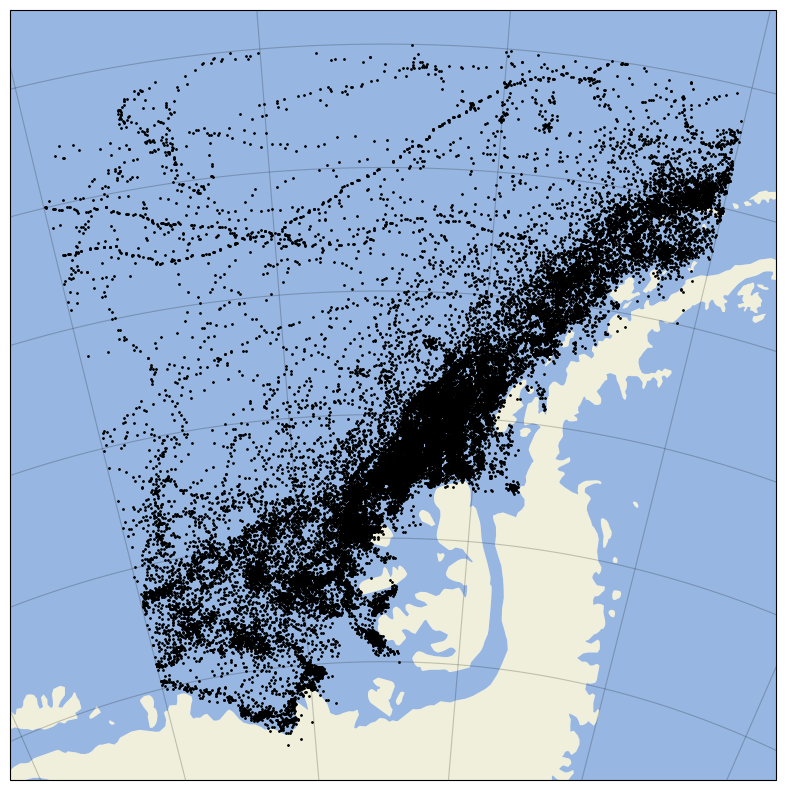

In [8]:
ax = cartopy_map(df['longitude (degrees_east)'], df['latitude (degrees_north)'])
ax.scatter(df['longitude (degrees_east)'], df['latitude (degrees_north)'], transform=ccrs.PlateCarree(), color='k', s=1)


### 2. Add argo data

We use a bounding box from the lon, lat and time of the seal data to look for co-located Argo floats on the ifremer ERDDAP

In [9]:
e_ifremer = ERDDAP(
    server="https://erddap.ifremer.fr/erddap",
    protocol="tabledap"
)
e_ifremer.dataset_id = "ArgoFloats"

In [10]:
e_ifremer.constraints = {'time>=': df["time (UTC)"].min(),
 'time<=': df["time (UTC)"].max(),
 'latitude>=':  df['latitude (degrees_north)'].min(),
 'latitude<=':  df['latitude (degrees_north)'].max(),
 'longitude>=': df['longitude (degrees_east)'].min(),
 'longitude<=': df['longitude (degrees_east)'].max(),}
#e_ifremer.variables = ['latitude', 'longitude', 'time']

In [11]:
df_argo = e_ifremer.to_pandas()
df_argo

/home/callum/mambaforge/envs/goosdemo/lib/python3.11/site-packages/erddapy/core/interfaces.py:33: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(data, **(pandas_kwargs or {}))


,fileNumber,data_type,format_version,handbook_version,reference_date_time (UTC),date_creation (UTC),date_update (UTC),platform_number,project_name,pi_name,...,temp_doxy (degree_Celsius),temp_doxy_qc,molar_doxy (micromole/l),molar_doxy_qc,turbidity (ntu),turbidity_qc,chla (mg/m3),chla_qc,nitrate (micromole/kg),nitrate_qc
0,1901574,Argo profile,3.1,1.2,1950-01-01T00:00:00Z,2012-03-17T03:48:55Z,2019-06-24T15:47:11Z,1901574,US ARGO PROJECT,BRECK OWENS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1901574,Argo profile,3.1,1.2,1950-01-01T00:00:00Z,2012-03-17T03:48:55Z,2019-06-24T15:47:11Z,1901574,US ARGO PROJECT,BRECK OWENS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1901574,Argo profile,3.1,1.2,1950-01-01T00:00:00Z,2012-03-17T03:48:55Z,2019-06-24T15:47:11Z,1901574,US ARGO PROJECT,BRECK OWENS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1901574,Argo profile,3.1,1.2,1950-01-01T00:00:00Z,2012-03-17T03:48:55Z,2019-06-24T15:47:11Z,1901574,US ARGO PROJECT,BRECK OWENS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1901574,Argo profile,3.1,1.2,1950-01-01T00:00:00Z,2012-03-17T03:48:55Z,2019-06-24T15:47:11Z,1901574,US ARGO PROJECT,BRECK OWENS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114155,5901536,Argo profile,3.1,1.2,1950-01-01T00:00:00Z,2007-03-30T22:03:31Z,2019-04-05T22:14:11Z,5901536,J-ARGO,JAMSTEC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1114156,5901536,Argo profile,3.1,1.2,1950-01-01T00:00:00Z,2007-03-30T22:03:31Z,2019-04-05T22:14:11Z,5901536,J-ARGO,JAMSTEC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1114157,5901536,Argo profile,3.1,1.2,1950-01-01T00:00:00Z,2007-03-30T22:03:31Z,2019-04-05T22:14:11Z,5901536,J-ARGO,JAMSTEC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1114158,5901536,Argo profile,3.1,1.2,1950-01-01T00:00:00Z,2007-03-30T22:03:31Z,2019-04-05T22:14:11Z,5901536,J-ARGO,JAMSTEC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
list(df_argo)

['fileNumber',
 'data_type',
 'format_version',
 'handbook_version',
 'reference_date_time (UTC)',
 'date_creation (UTC)',
 'date_update (UTC)',
 'platform_number',
 'project_name',
 'pi_name',
 'cycle_number',
 'direction',
 'data_center',
 'dc_reference',
 'data_state_indicator',
 'data_mode',
 'platform_type',
 'float_serial_no',
 'firmware_version',
 'wmo_inst_type',
 'time (UTC)',
 'time_qc',
 'time_location (UTC)',
 'latitude (degrees_north)',
 'longitude (degrees_east)',
 'position_qc',
 'positioning_system',
 'profile_pres_qc',
 'profile_temp_qc',
 'profile_psal_qc',
 'vertical_sampling_scheme',
 'config_mission_number',
 'pres (decibar)',
 'pres_qc',
 'pres_adjusted (decibar)',
 'pres_adjusted_qc',
 'pres_adjusted_error (decibar)',
 'temp (degree_Celsius)',
 'temp_qc',
 'temp_adjusted (degree_Celsius)',
 'temp_adjusted_qc',
 'temp_adjusted_error (degree_Celsius)',
 'psal (PSU)',
 'psal_qc',
 'psal_adjusted (PSU)',
 'psal_adjusted_qc',
 'psal_adjusted_error (psu)',
 'doxy (micr

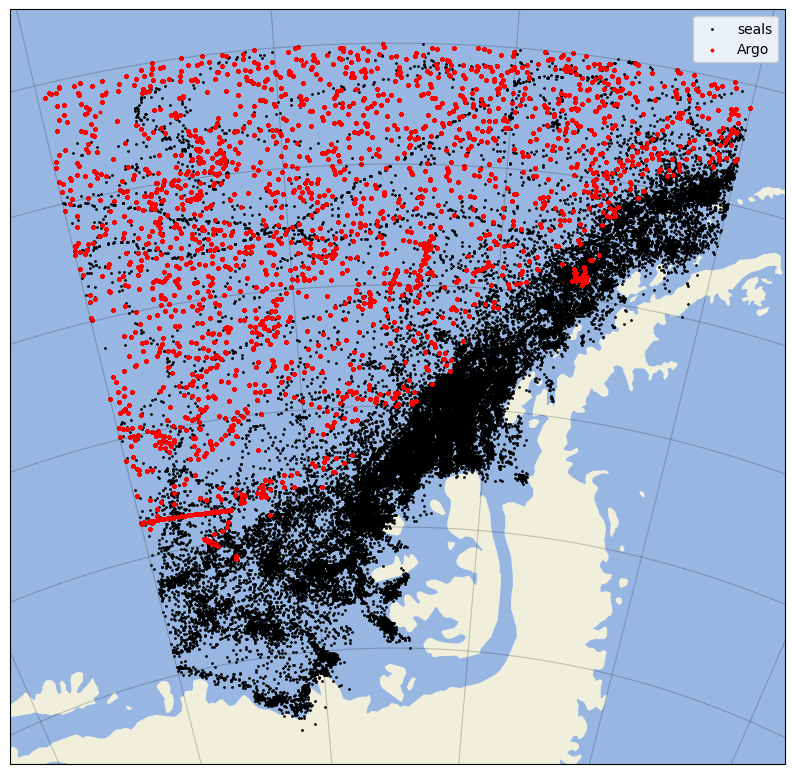

In [13]:
ax = cartopy_map(df['longitude (degrees_east)'], df['latitude (degrees_north)'])
ax.scatter(df['longitude (degrees_east)'], df['latitude (degrees_north)'], transform=ccrs.PlateCarree(), color='k', s=1, label="seals")
ax.scatter(df_argo['longitude (degrees_east)'], df_argo['latitude (degrees_north)'], transform=ccrs.PlateCarree(), color="r", s=3, label="Argo")
ax.legend()

### 3. Gridded SST

Finally, we get some matching JPL reanalysis SST data from the coastwatch ERDDAP 

In [14]:
coastwatch_e = ERDDAP(
    server="https://coastwatch.pfeg.noaa.gov/erddap",
    protocol="griddap",
)
coastwatch_e.dataset_id='jplMURSST41'
coastwatch_e.griddap_initialize() 

In [15]:
coastwatch_e.constraints = {'time>=': df["time (UTC)"].min(),
 'time<=': df["time (UTC)"].max(),
 'time_step': 365,
 'latitude>=':  df['latitude (degrees_north)'].min(),
 'latitude<=':  df['latitude (degrees_north)'].max(),
 'latitude_step': 10,
 'longitude>=': df['longitude (degrees_east)'].min(),
 'longitude<=': df['longitude (degrees_east)'].max(),
 'longitude_step': 10}

coastwatch_e.variables=['analysed_sst']

In [16]:
ds = coastwatch_e.to_xarray()

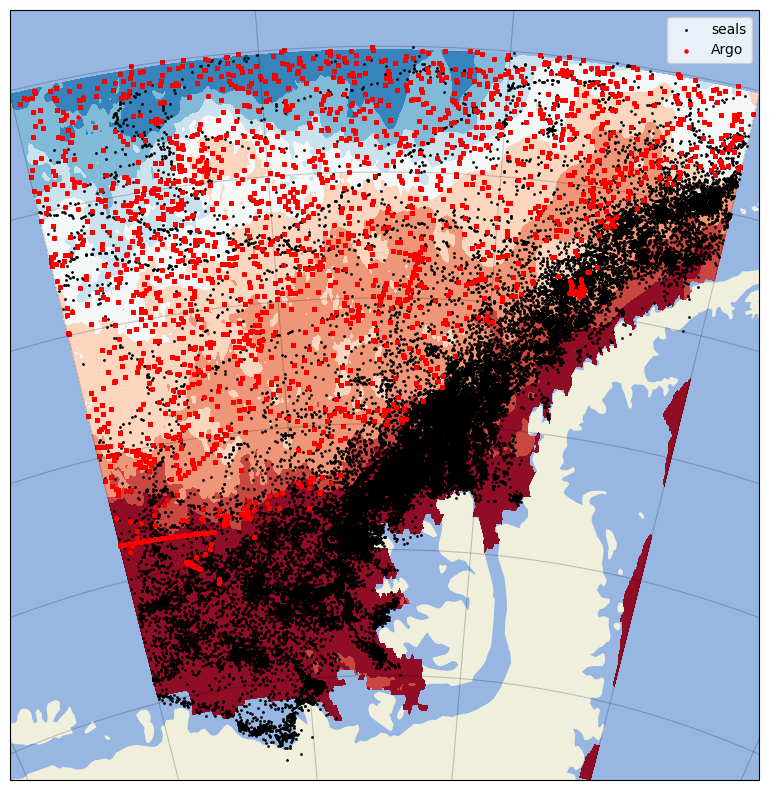

In [17]:
ax = cartopy_map(df['longitude (degrees_east)'], df['latitude (degrees_north)'])
ax.contourf(ds.longitude, ds.latitude, ds.analysed_sst[0,:,:], transform=ccrs.PlateCarree(), cmap="RdBu")
ax.scatter(df['longitude (degrees_east)'], df['latitude (degrees_north)'], transform=ccrs.PlateCarree(), color='k', s=1, label="seals")
ax.scatter(df_argo['longitude (degrees_east)'], df_argo['latitude (degrees_north)'], transform=ccrs.PlateCarree(), color="r", s=5, label="Argo")
ax.legend()

We will cover more on the use of the griddap protocol in the next session

**Bonus**: change the species to 'Crabeater seal' and re-run the notebook

---------------------------
### References

MEOP data from https://meop.net

Argo data from ifremer https://erddap.ifremer.fr/erddap/tabledap/ArgoFloats.html

SST reanalysis from coastwatch https://coastwatch.pfeg.noaa.gov/erddap

More info on using ERDDAP's inbuilt search https://ioos.github.io/erddapy/01b-tabledap-output.html